In [1]:
import torch
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import pickle
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.cm as cm
%matplotlib inline

sys.path.append('..')
from src.embedding.gym_dataset import AbstractActionsData
from src.embedding.gym_dataset import GymData
from src.embedding.gym_dataset import load_or_generate

In [52]:
import wandb

wandb.init(project='dyne-visualise', entity='vinnibuh')

_runtime,116
_timestamp,1623668716
_step,0


_runtime,▁
_timestamp,▁
_step,▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
encoder = torch.load('../models/encoder/dmc_walker_walk/DynE-4/encoder.pt')
data = AbstractActionsData('dmc_walker_walk', 4, encoder)

gym_data = torch.load('../datasets/torch/dmc_walker_walk_len4_n100000_qposFalse_qvelFalse_deltaTrue_whitenTrue_pixelsFalse.pt')
data.mean, data.std = gym_data.mean, gym_data.std

del gym_data

# data.load_from_directory('../datasets/dreamer/dmc_walker_walk/1/episodes')

In [4]:
from dm_control import suite

In [6]:
env = suite.load('walker', 'walk')

In [12]:
episode = np.load('../datasets/dreamer/dmc_walker_walk/1/episodes/20210610T175945-076f81e30b9c4571a05789622488a396-501.npz')

In [13]:
episode = {k: torch.from_numpy(episode[k]).float() for k in episode.keys()}

In [21]:
episode['obs'] = torch.cat([episode['orientations'],
                                                            torch.unsqueeze(episode['height'], 1),
                                                            episode['velocity']], 1)

In [22]:
episode['obs'].shape

torch.Size([501, 24])

In [9]:
env.observation_spec()

OrderedDict([('orientations',
              Array(shape=(14,), dtype=dtype('float64'), name='orientations')),
             ('height',
              Array(shape=(), dtype=dtype('float64'), name='height')),
             ('velocity',
              Array(shape=(9,), dtype=dtype('float64'), name='velocity'))])

In [ ]:
wandb.finish()

In [9]:
raw_obs, raw_action, raw_reward = data[0]
raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])

mu, logvar, _ = data.transform_episode(0)

numbers_ak = []
rewards_ak = []
embeddings_ak = []
for k in range(100):
    raw_obs, raw_action, raw_reward = data[k]
    raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])
    rewards = raw_reward[1:].reshape([250, 2]).sum(axis=1)
    for idx, vector in enumerate(raw_embeddings):
        embeddings_ak.append(vector.numpy())
        numbers_ak.append(idx)
        rewards_ak.append(rewards[idx])
    
#tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
#embeddings_ak_2d = tsne_ak_2d.fit_transform(np.array(embeddings_ak))
print('done')

dyne_numbers_ak = []
dyne_emb_ak = []
for k in range(100):
    mu, logvar, _ = data.transform_episode(k)
    for idx, vector in enumerate(mu):
        dyne_emb_ak.append(vector.numpy())
        dyne_numbers_ak.append(idx)
    
#tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
#embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(np.array(dyne_emb_ak))

done


In [11]:
embeddings_ak_2d = np.load('raw_actions_tsne_emb.npy')
embeddings_dyne_ak_2d = np.load('dyne_actions_tsne_emb.npy')

In [43]:
def tsne_plot_2d(label, embeddings, color_style='time', rewards=[], a_points=1, a_text=0.6, size=15, 
                 log=False, wandb_label=None, ax=None, episodes_num=100):
    ax = plt if ax is None else ax
    if color_style == 'time':
        colors = cm.coolwarm(np.linspace(0, 1, int(len(embeddings)/episodes_num)))
        colors = np.tile(colors, (episodes_num, 1))
    elif color_style == 'rewards':
        rewards = np.array(rewards)
        scaled_rewards = rewards / rewards.max()
        colors = cm.coolwarm(scaled_rewards)
    elif color_style == 'episodes':
        colors = cm.coolwarm(np.linspace(0, 1, episodes_num))
        colors = np.repeat(colors, int(len(embeddings)/episodes_num), 0)
    x = embeddings[:,0]
    y = embeddings[:,1]
    ax.scatter(x, y, s=size, c=colors, alpha=a_points, label=label)
    ax.legend(loc=2)
    ax.grid(True)
    # ax.savefig("{}.png".format(label), format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb_label = label if wandb_label is None else wandb_label
        wandb.log({wandb_label: wandb.Image(plt)})

In [50]:
def compare_embeddings_vis_2d(task, label, data, n_samples, a_points=1, a_text=0.6, log=False):
    sample_idx = random.sample(range(len(data)), n_samples)
    
    raw_obs, raw_action, raw_reward = data[0]
    raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])

    mu, logvar = data.transform_episode(0)

    numbers_ak = []
    rewards_ak = []
    embeddings_ak = []
    for k in sample_idx:
        raw_obs, raw_action, raw_reward = data[k]
        raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])
        rewards = raw_reward[1:].reshape([250, 2]).sum(axis=1)
        for idx, vector in enumerate(raw_embeddings):
            embeddings_ak.append(vector.numpy())
            numbers_ak.append(idx)
            rewards_ak.append(rewards[idx])
    
    tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
    embeddings_ak_2d = tsne_ak_2d.fit_transform(np.array(embeddings_ak))

    dyne_numbers_ak = []
    dyne_emb_ak = []
    for k in sample_idx:
        mu, logvar, _ = data.transform_episode(k)
        for idx, vector in enumerate(mu):
            dyne_emb_ak.append(vector.numpy())
            dyne_numbers_ak.append(idx)
    
    tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
    embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(np.array(dyne_emb_ak))
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    tsne_plot_2d('raw actions by time'.format(task), embeddings_ak_2d, 
                 color_style='time', rewards=rewards_ak, size=10, a_text=0, 
                 log=False, ax=axes[0][0], episodes_num=n_samples)
    
    tsne_plot_2d('dyne actions by time'.format(task), embeddings_dyne_ak_2d, 
                 color_style='time', rewards=rewards_ak, size=10, a_text=0, 
                 log=False, ax=axes[0][1], episodes_num=n_samples)
    
    tsne_plot_2d('raw actions by rewards'.format(task), embeddings_ak_2d, 
                 color_style='rewards', rewards=rewards_ak, size=10, a_text=0, 
                 log=False, ax=axes[1][0], episodes_num=n_samples)
    
    tsne_plot_2d('dyne actions by rewards'.format(task), embeddings_dyne_ak_2d, 
                 color_style='rewards', rewards=rewards_ak, size=10, a_text=0, 
                 log=False, ax=axes[1][1], episodes_num=n_samples)
    
    fig.suptitle(label, fontsize=16)
    fig.savefig("{}.png".format(label), format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({'Embeddings Comparison': wandb.Image(fig)})

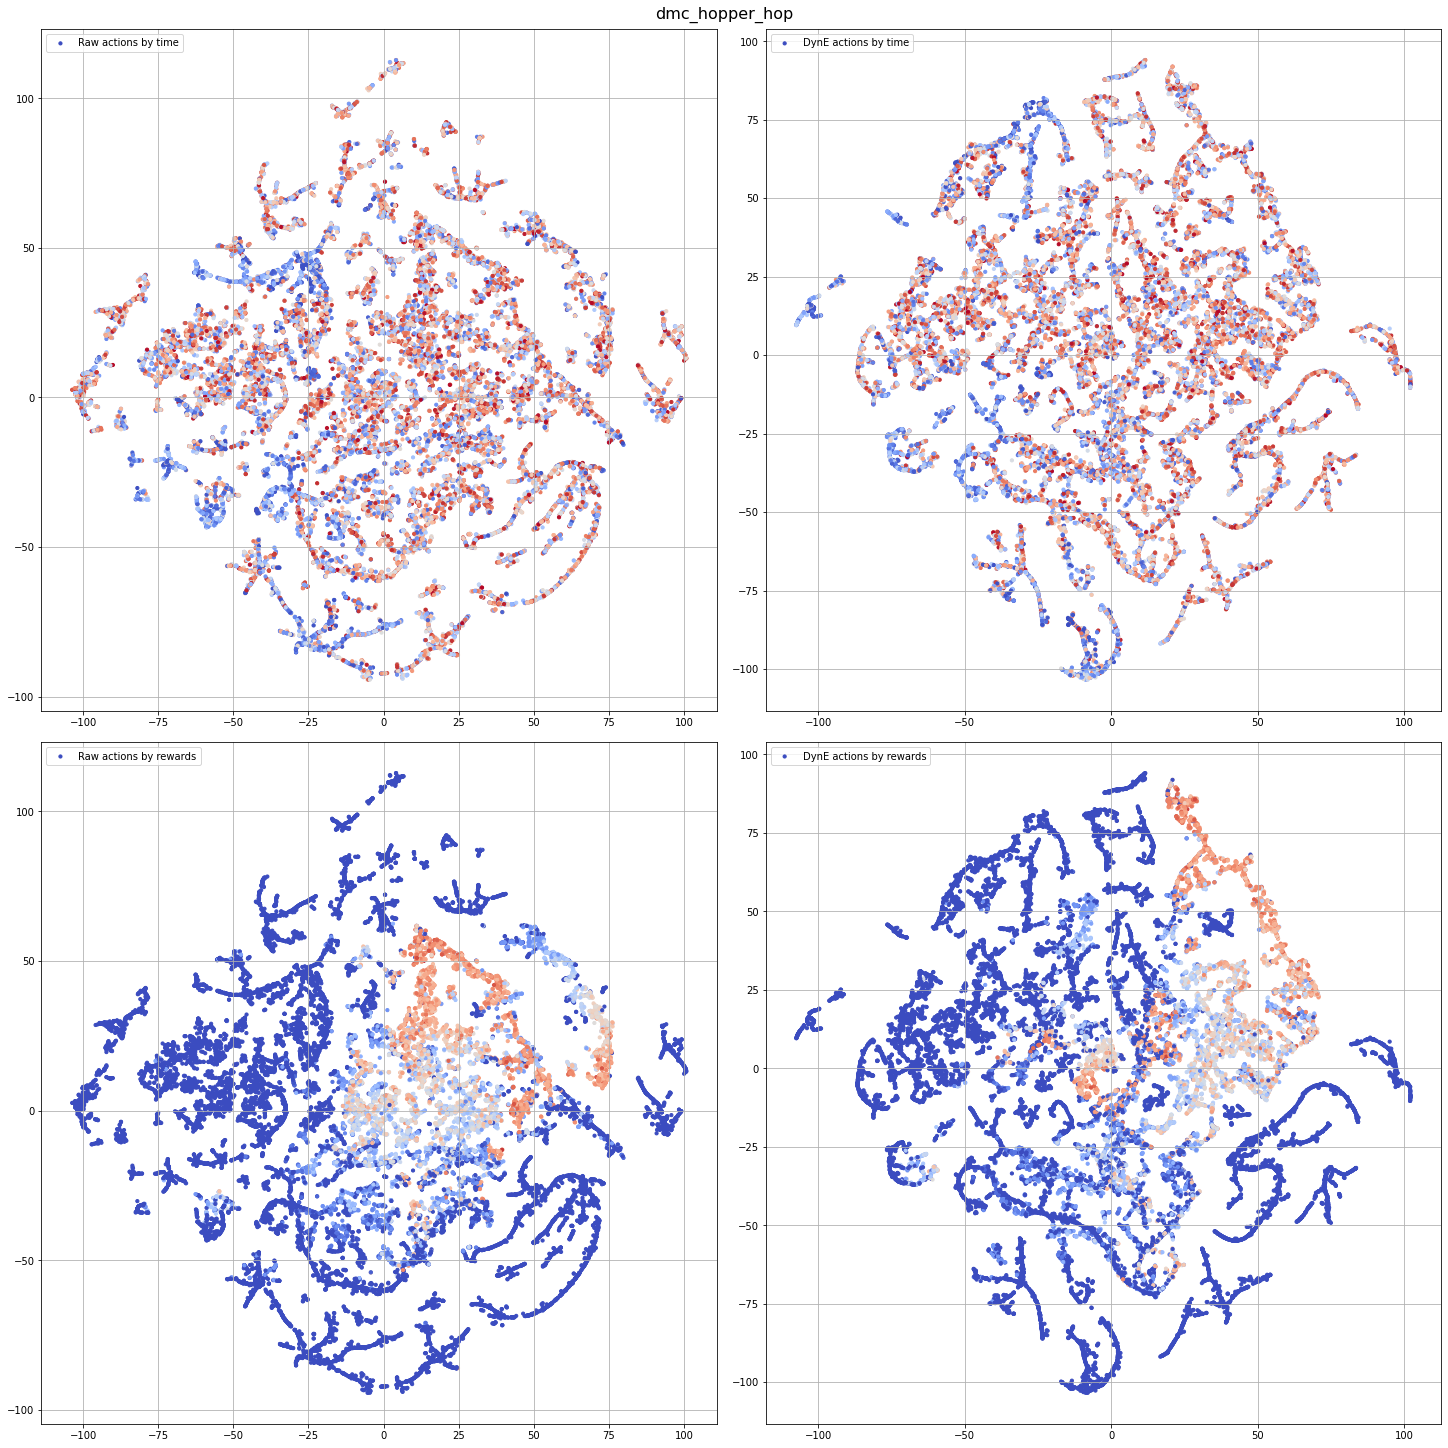

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True)
tsne_plot_2d('Raw actions by time', embeddings_ak_2d, 
             color_style='time', rewards=rewards_ak, size=10, a_text=0, 
             log=False, ax=axes[0][0])

tsne_plot_2d('DynE actions by time', embeddings_dyne_ak_2d, 
             color_style='time', rewards=rewards_ak, size=10, a_text=0, 
             log=False, ax=axes[0][1])

tsne_plot_2d('Raw actions by rewards', embeddings_ak_2d, 
             color_style='rewards', rewards=rewards_ak, size=10, a_text=0, 
             log=False, ax=axes[1][0])

tsne_plot_2d('DynE actions by rewards', embeddings_dyne_ak_2d, 
             color_style='rewards', rewards=rewards_ak, size=10, a_text=0, 
             log=False, ax=axes[1][1])
fig.suptitle('dmc_hopper_hop', fontsize=16)
wandb.log({'Embeddings Comparison': wandb.Image(fig)})

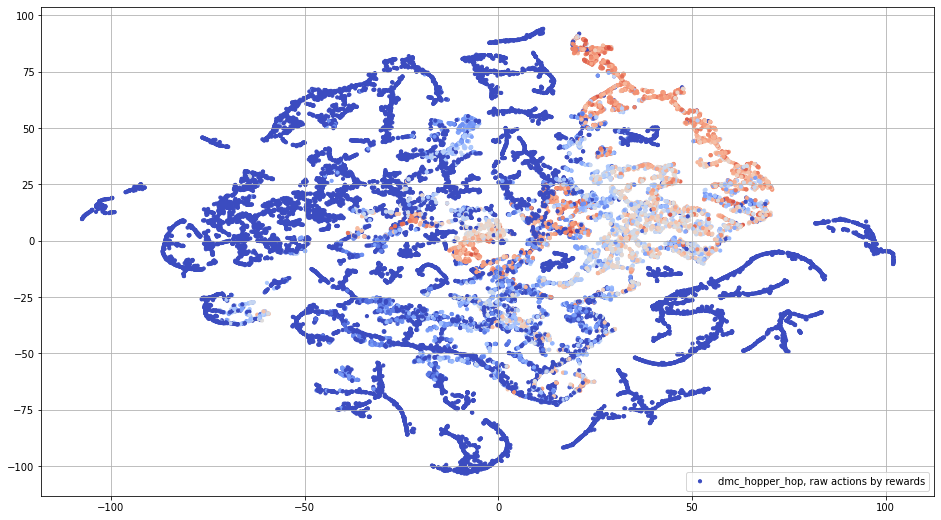

In [21]:
tsne_plot_2d('dmc_hopper_hop, dyne actions by rewards', embeddings_dyne_ak_2d, 
             color_style='rewards', rewards=rewards_ak, a_text=0, size=10, 
             log=True, wandb_label='dyne actions by rewards, 100 episodes')

In [4]:
def vis_embeddings(label, embeddings, words=[], a_points=1, a_text=0.6, ax=None):
    colors = cm.coolwarm(np.linspace(0, 1, len(embeddings)))
    x = embeddings[:,0]
    y = embeddings[:,1]
    ax.scatter(x, y, c=colors, alpha=a_points, label=label)
    for i, word in enumerate(words):
        ax.annotate(word, alpha=a_text, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    ax.legend(loc=4)
    ax.grid(True)

def compare_embeddings_vis_2d(label, data, n_samples, a_points=1, a_text=0.6, log=False):
    sample_idx = random.sample(range(len(data)), n_samples)
    fig, axes = plt.subplots(n_samples, 2, figsize=(30, 60))
    
    for idx, s in enumerate(sample_idx):
        
        raw_obs, raw_action, raw_reward = data[s]
        raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])

        mu, logvar = data.transform_episode(s)

        numbers_ak = []
        embeddings_ak = []
        for k, vector in enumerate(raw_embeddings):
            embeddings_ak.append(vector.numpy())
            numbers_ak.append(k)
    
        tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)
        
        vis_embeddings("episode {}, raw actions".format(s), embeddings_ak_2d, 
                       numbers_ak, a_text=0, ax=axes[idx][0])

        dyne_numbers_ak = []
        dyne_emb_ak = []

        for k, vector in enumerate(mu):
            dyne_emb_ak.append(vector.numpy())
            dyne_numbers_ak.append(k)
    
        tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(dyne_emb_ak)
        
        vis_embeddings("episode {}, dyne actions".format(s), embeddings_dyne_ak_2d, 
                       dyne_numbers_ak, a_text=0, ax=axes[idx][1])
        
    fig.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({label: wandb.Image(fig)})
    else:
        plt.show()

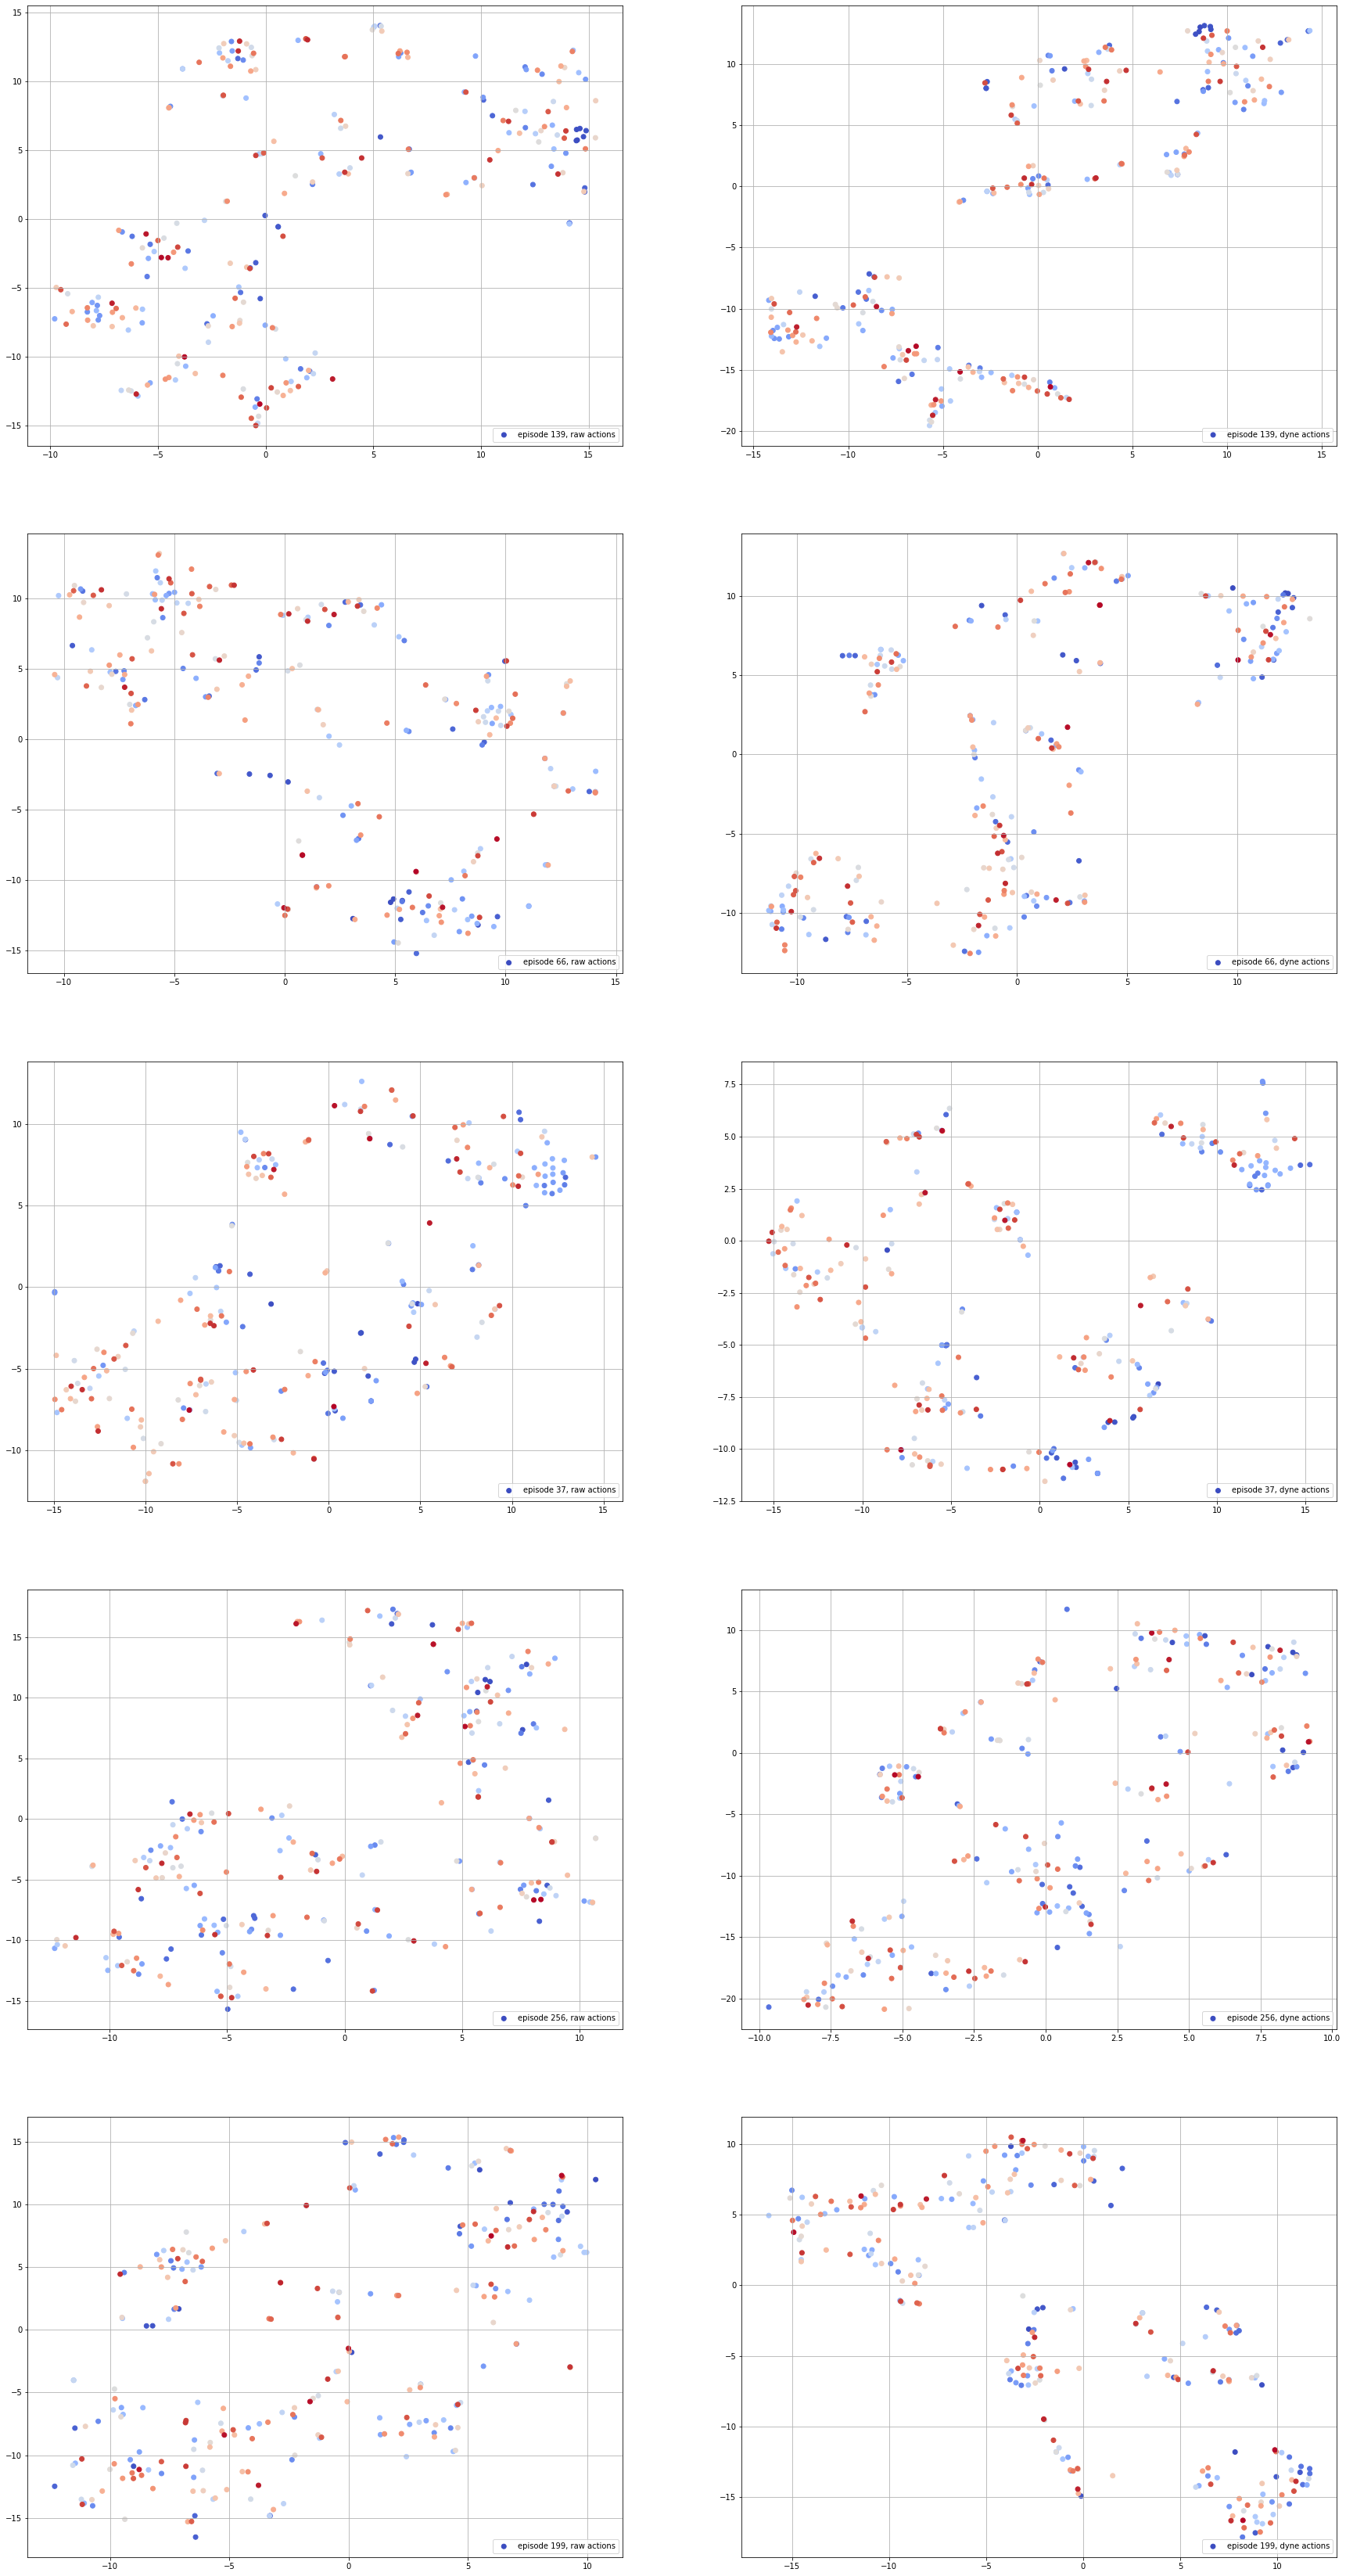

In [136]:
compare_embeddings_vis_2d('raw vs dyne actions', data, 5, a_text=0, log=True)

In [7]:
def vis_embeddings(label, embeddings, words=[], a_points=1, a_text=0.6, ax=None):
    colors = cm.coolwarm(np.linspace(0, 1, len(embeddings)))
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    ax.scatter(x, y, c=colors, alpha=a_points, label=label)
    for i, word in enumerate(words):
        ax.annotate(word, alpha=a_text, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=10)
    ax.legend(loc=4)
    ax.grid(True)
    
def compare_embeddings_vis_2d(traj_len, label, data, n_samples, a_points=1, a_text=0.6, log=True, images_path=None):
    sample_idx = random.sample(range(len(data)), n_samples)
    fig, axes = plt.subplots(n_samples, 2, figsize=(30, 60))

    for idx, s in enumerate(sample_idx):

        raw_obs, raw_action, raw_reward = data[s]
        raw_action = torch.repeat_interleave(raw_action[1:], 2, dim=0)
        action_dim = raw_action.size(1)
        initial_episode_size = raw_action.size(0)
        actual_episode_size = initial_episode_size - (initial_episode_size % traj_len)
        raw_action = raw_action[:actual_episode_size]
        raw_embeddings = raw_action.reshape([actual_episode_size // traj_len,
                                             traj_len * action_dim])

        mu, logvar = data.transform_episode(s)

        numbers_ak = []
        embeddings_ak = []
        for k, vector in enumerate(raw_embeddings):
            embeddings_ak.append(vector.numpy())
            numbers_ak.append(k)

        tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

        vis_embeddings("episode {}, raw actions".format(s), embeddings_ak_2d,
                       numbers_ak, a_points=a_points, a_text=a_text, ax=axes[idx][0])

        dyne_numbers_ak = []
        dyne_emb_ak = []

        for k, vector in enumerate(mu):
            dyne_emb_ak.append(vector.numpy())
            dyne_numbers_ak.append(k)

        tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(dyne_emb_ak)

        vis_embeddings("episode {}, dyne actions".format(s), embeddings_dyne_ak_2d,
                       dyne_numbers_ak, a_points=a_points, a_text=a_text, ax=axes[idx][1])

    fig.savefig(images_path / 'comparison.png', format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({label: wandb.Image(fig)})
    else:
        plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

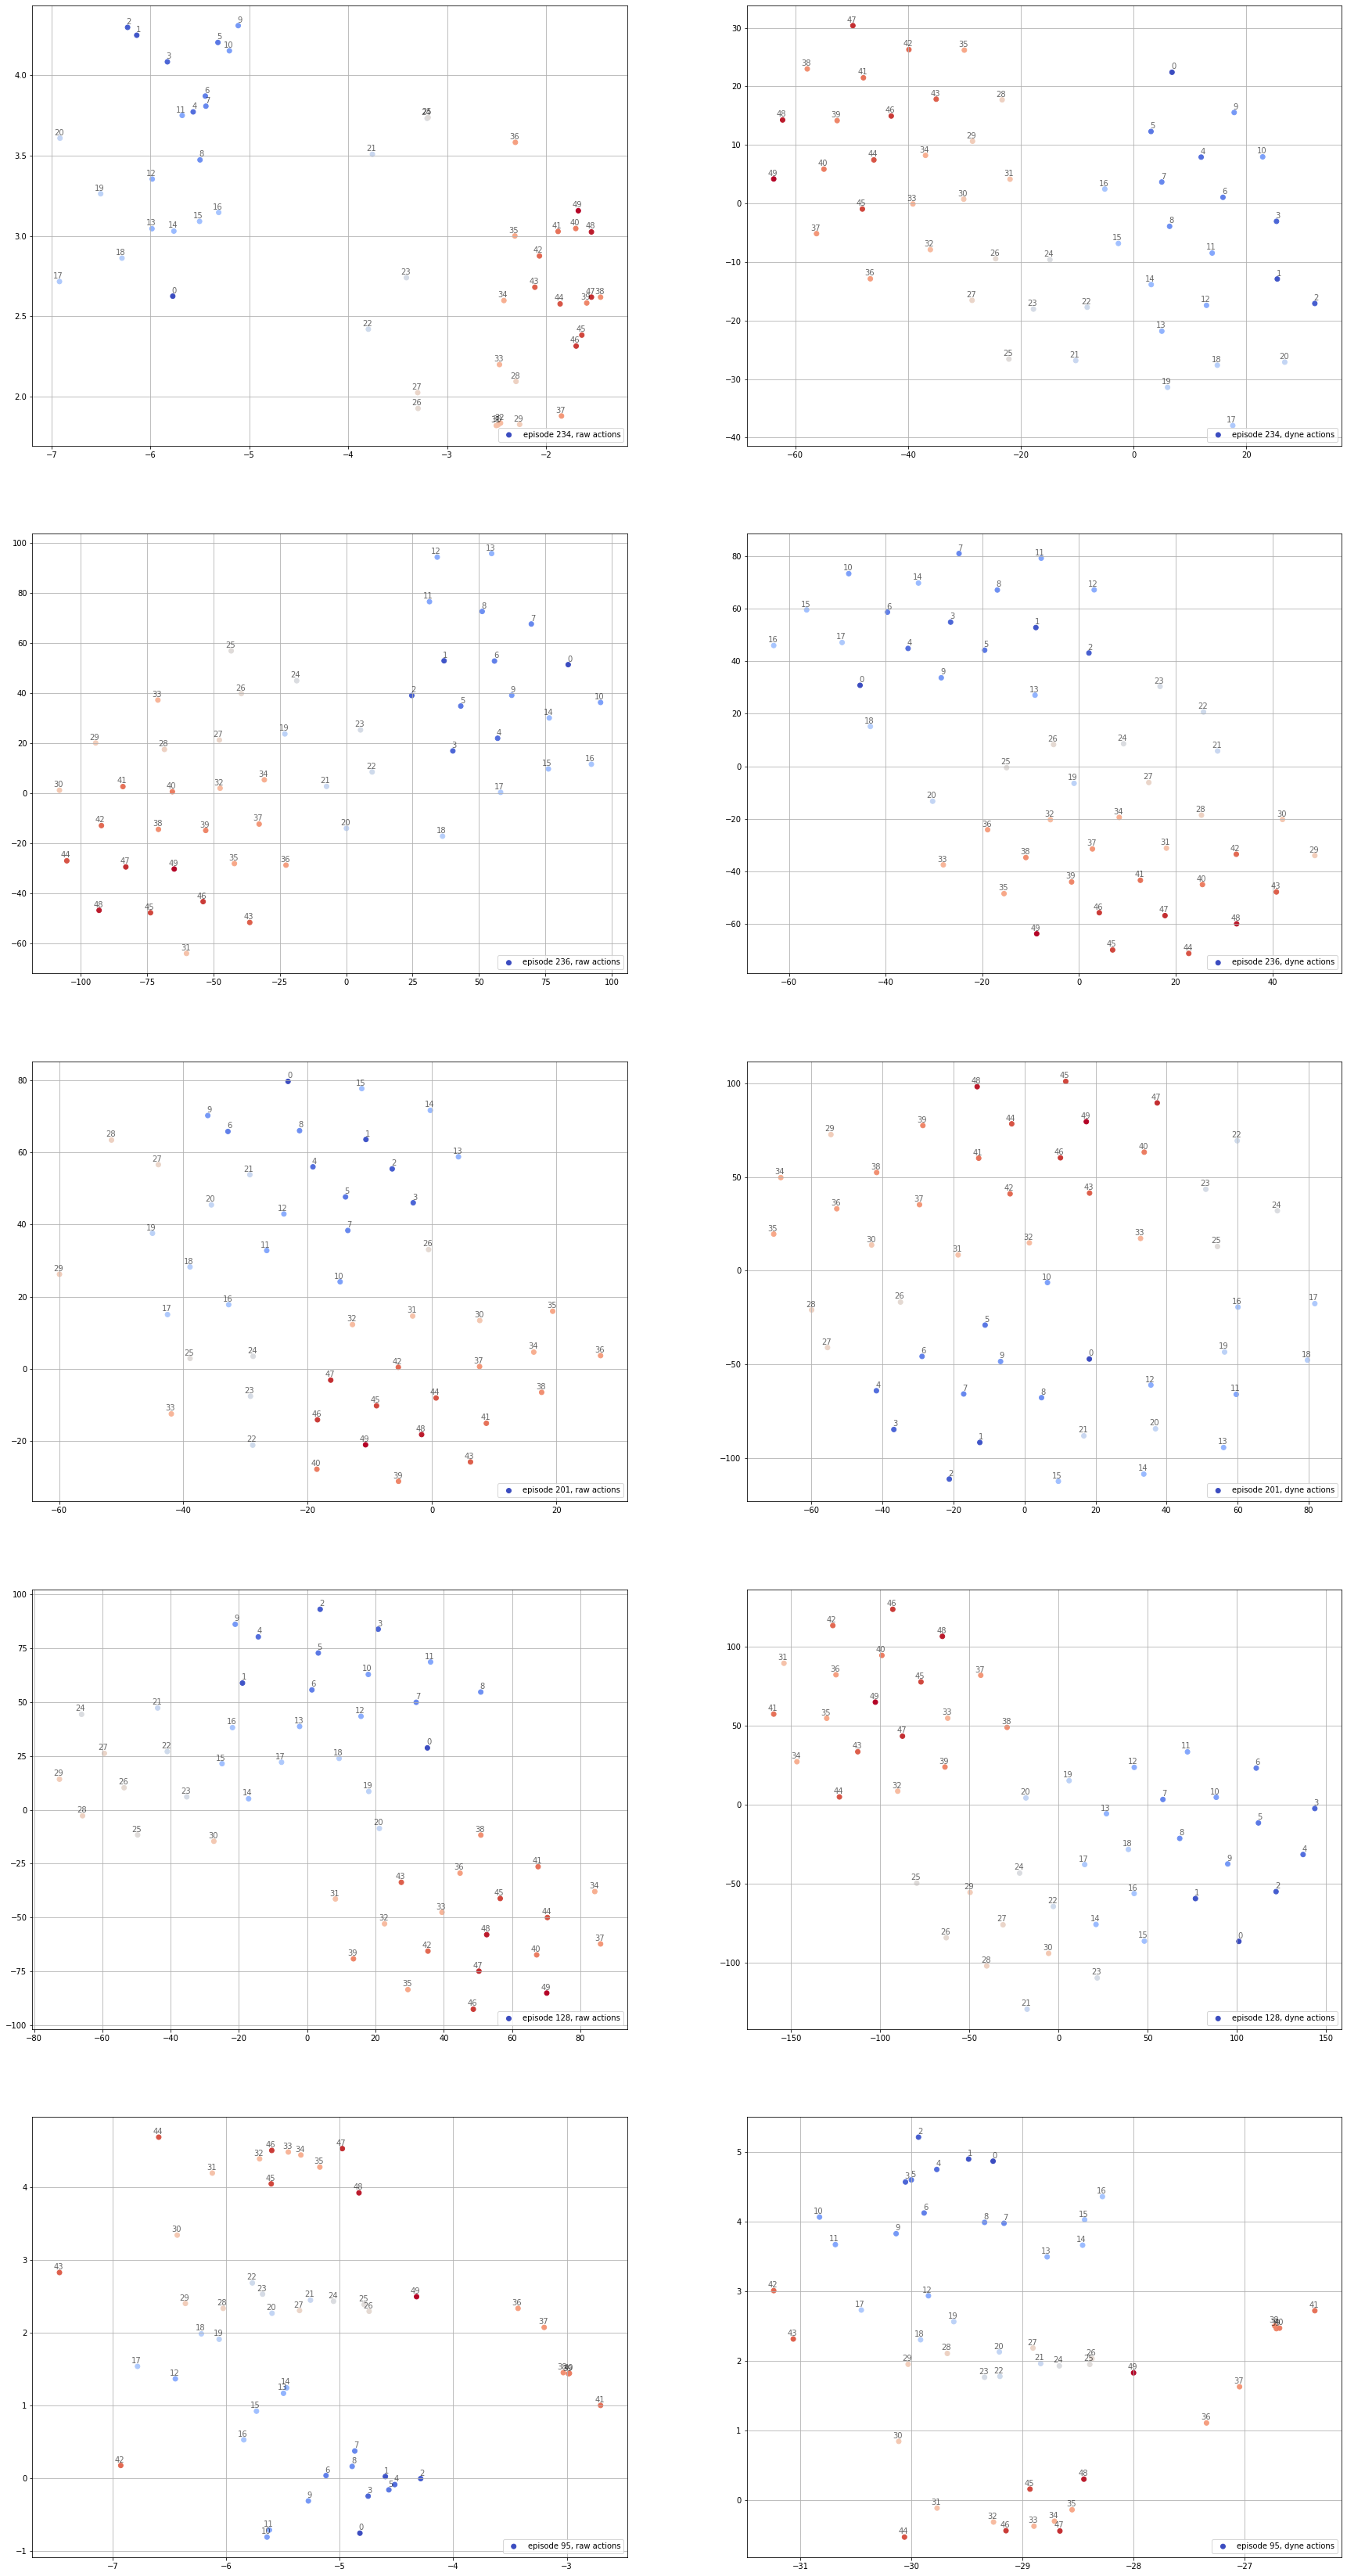

In [8]:
import pathlib

compare_embeddings_vis_2d(4, 'raw vs dyne', data, 5, log=False, images_path = pathlib.Path('./try.png'))